# Обучение без учителя с частотным кодированием
Здесь на простом примере показано, как сеть обучается распознавать классы входных сигналов. 
* генерация обучающих примеров
* создание сети
* обучение сети по правилу STDP
* назначение классов нейронам и оценка качества

## Задание
Дополнение в лабораторную работу №2:
* Научить сеть различать минимум 4 класса входных изображений 3*3
* Проверить эффективность нормализации весов после предъявления каждого изображения так, чтобы сумма всегда была равна $g_{max}$


## References

[1] Diehl, P. U., & Cook, M. (2015). Unsupervised learning of digit recognition using spike-timing-dependent plasticity. Frontiers in computational neuroscience, 9, 99 

[2] https://www.kaggle.com/code/dlarionov/mnist-spiking-neural-network/notebook

In [1]:
!pip install brian2
!pip install --upgrade numpy
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 5.1 MB/s 
     |████████████████████████████████| 965 kB 35.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import brian2 as b2

## Генерация данных
* Сгенерируем эталонные картинки - образцы классов
* Сгенерируем набор зашумленных картинок
* Разобьем на обучающую и тестовую выборки

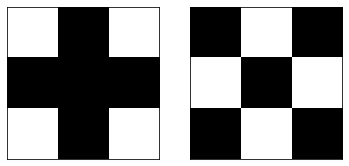

In [2]:
def draw_patterns(patterns, figsize=(6,4)):
  fig, ax = plt.subplots(nrows = 1, ncols = len(patterns), figsize=figsize)
  for i,p in enumerate(patterns):
    ax[i].imshow(patterns[i], cmap='Greys')
    ax[i].tick_params(axis='both', labelbottom=False, labeltop=False, labelleft=False, labelright=False,
                             bottom=False, top=False, left=False, right=False)

#left_up = np.array([1, 0, 0,
#                 0, 1, 0,
#                 0, 0, 1]).reshape(3,3)
#left_bottom = np.array([0, 0, 1,
#                  0, 1, 0,
#                  1, 0, 0]).reshape(3,3)
plus = np.array([0, 1, 0,
                 1, 1, 1,
                 0, 1, 0]).reshape(3,3)
cross = np.array([1, 0, 1,
                  0, 1, 0,
                  1, 0, 1]).reshape(3,3)
patterns = [plus, cross]
draw_patterns(patterns)

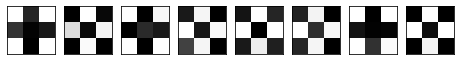

In [3]:
from sklearn.model_selection import train_test_split
N_SAMPLE_CLASS = 30
rng = np.random.default_rng()
X,y = [],[]
sigma = 0.15
for i_p,p in enumerate(patterns):
  for _ in range(N_SAMPLE_CLASS):
    X += [np.clip(p + sigma*rng.standard_normal(p.shape),0,1)]
    y += [i_p]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
draw_patterns(X_train[-8:], figsize=(8,5))

# Частотное кодирование
Яркость пикселя $r_i$ преобразуется в частоту спайков
$$
\lambda_i=r_i\lambda_{max}
$$

## Создаем сеть
* Входной слой, кол-во нейронов равно кол-ву пикселей
* Выходной слой, кол-во нейронов должно быть не меньше кол-ва классов
* STDP синапсы
* Синапсы латерального торможения

In [4]:
#These parameters must be in the global namespace area
taum = 10*b2.ms
taue = 5*b2.ms
taui = 10*b2.ms
v_rest = -74*b2.mV
vt = -54*b2.mV
vr = -60*b2.mV
Ee = 0*b2.mV
Ei = -100*b2.mV

def create_input(size):
  input_group = b2.PoissonGroup(size, rates=np.zeros(size)*b2.Hz, 
                              name='PG')  
  s_mon_inp = b2.SpikeMonitor(input_group)
  return input_group, s_mon_inp

def create_exc_neurons(size):
  neuron_eq = '''
            dv/dt = (v_rest - v + ge * (Ee - v) + gi * (Ei - v)) / taum : volt
            dge/dt = -ge / taue : 1
            dgi/dt = -gi / taui : 1
            '''
  neurons = b2.NeuronGroup(size, neuron_eq, threshold='v>vt', reset='v = vr',
                      method='euler')
  neurons.v = v_rest
  neurons.ge=0
  neurons.gi=0
  s_mon_nrn = b2.SpikeMonitor(neurons)
  return neurons, s_mon_nrn

taupre=20*b2.ms
taupost=20*b2.ms
gmax=0.2
gi_max = gmax
max_delay_i = 10*b2.ms
dApre=0.01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

def create_stdp_synapses(pre_group, post_group):
  S = b2.Synapses(pre_group, post_group,
             '''w : 1
                stdp_rate : 1 (shared)
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + stdp_rate*Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + stdp_rate*Apre, 0, gmax)''',
             )
  S.connect()
  S.w = 'rand() * gmax'
  S.stdp_rate = 1
  mon = b2.StateMonitor(S, 'w', record=True)
  return S, mon

def create_inh_synapses(neuron_group):
  S = b2.Synapses(neuron_group, neuron_group,
             '''w : 1
                ''',
             on_pre='''gi += w''',
             )
  S.connect('i!=j')
  S.delay = "max_delay_i*rand()"
  S.w = gi_max  
  return S


In [5]:
out = 2
b2.start_scope()
input_layer, mon_input = create_input(patterns[0].size)
exc_layer, mon_exc = create_exc_neurons(out)
stdp_synapses, mon_stdp = create_stdp_synapses(input_layer, exc_layer)
inh_synapses = create_inh_synapses(exc_layer)
b2.run(0*b2.ms)

In [6]:
w2 = [stdp_synapses.w[i::out]/np.sqrt(sum(stdp_synapses.w[i::out]**2)) for i in range(out)]

In [7]:
stdp_synapses.w = np.reshape(np.stack(w2).T, (9*out,))

Input layer: 9 neurons
Excitatory layer: 2 neurons
18 STDP synapses
2 inhibitory synapses


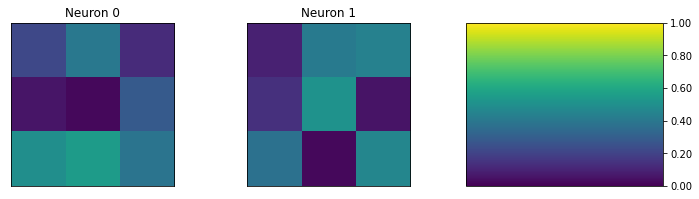

In [8]:
def plot_synapses(n_source, n_target, synapses, title=""):
  plt.figure(figsize=(3,3))
  W = np.full((n_source, n_target), np.nan)
  W[synapses.i[:], synapses.j[:]] = synapses.w[:]
  plt.imshow(W)
  plt.yticks(synapses.i)
  plt.xticks(synapses.j)
  plt.title(title)
  plt.xlabel("Target")
  plt.ylabel("Source")
  plt.colorbar(format="%4.2f")

def plot_input_synapses(synapses):
  #plt.figure(figsize=(16,5))
  fig,ax = plt.subplots(nrows=1, ncols=len(synapses.target)+1, figsize=(12,3))
  for j in range(len(synapses.target)):
    #W = np.full((3, 3), np.nan)
    #W[:, :] = 
    im = ax[j].imshow(np.reshape(synapses.w[:,j], (3,3)), vmin=0, vmax=1)
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    ax[j].set_title(f"Neuron {j}")
  fig.colorbar(im, cax = ax[-1], format="%4.2f")

print(f"Input layer: {len(input_layer)} neurons")
print(f"Excitatory layer: {len(exc_layer)} neurons")
print(f"{len(stdp_synapses)} STDP synapses")
print(f"{len(inh_synapses)} inhibitory synapses")
#plot_synapses(input_layer.N, exc_layer.N, stdp_synapses, "STDP weights")
#plot_synapses(exc_layer.N, exc_layer.N, inh_synapses, "Inhibitory weights")
plot_input_synapses(stdp_synapses)


## Обучение сети
Последовательно предъявляем все образы из обучающей выборки. Каждый образ предъявляется в течение T=150 мс. 

Training STDP weights has finished!


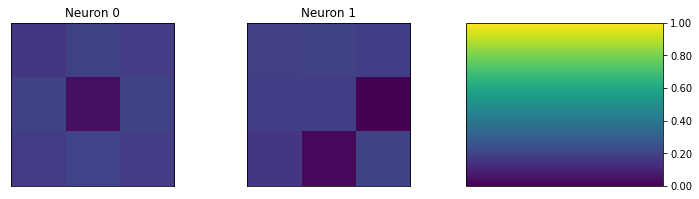

In [9]:
max_rate = 120 * b2.Hz
T_img = 150*b2.ms
T_rest = 50*b2.ms
for img in X_train:
  input_layer.rates = img.ravel()*max_rate
  b2.run(T_img, report=None)
  input_layer.rates = img.ravel()*0*b2.Hz
  b2.run(T_rest, report=None)
print("Training STDP weights has finished!")
plot_input_synapses(stdp_synapses)

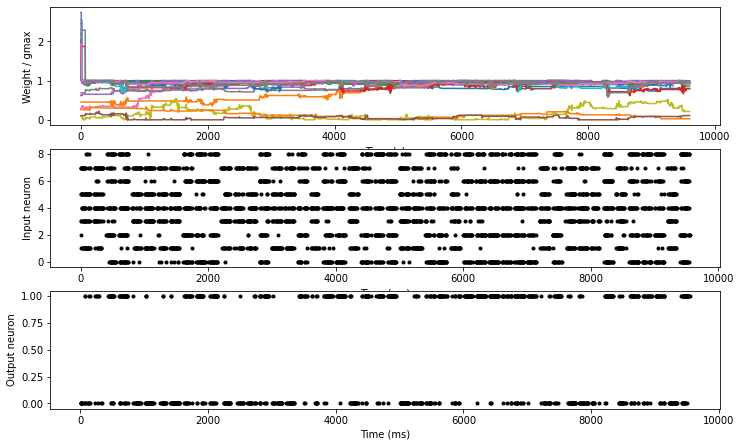

In [10]:
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(mon_stdp.t/b2.ms, mon_stdp.w.T/gmax)
plt.xlabel('Time (s)')
plt.ylabel('Weight / gmax')
plt.subplot(412)
plt.plot(mon_input.t/b2.ms, mon_input.i, '.k')
plt.xlabel('Time (ms)')
plt.ylabel('Input neuron')
#plt.yticks(range(0,len(input_rates)))
plt.subplot(413)
plt.plot(mon_exc.t/b2.ms, mon_exc.i, '.k')
plt.xlabel('Time (ms)')
plt.ylabel('Output neuron')
#plt.tight_layout()
plt.show()
#plot_synapses(input_layer.N, exc_layer.N, stdp_synapses, "STDP weights")

## Назначаем классы нейронам
Предъявляем сети по очереди изображения. Для каждого изображения подсчитываем количество спайков от каждого нейрона и сохраняем в массив.
Затем каждому нейрону назначаем класс в зависимости от того, на какой класс изображений он был больше всего активен.

[0 1]
[[17.  4.]
 [20.  0.]
 [11. 21.]
 [ 1. 29.]
 [10.  2.]
 [30.  0.]
 [21.  4.]
 [25.  5.]
 [ 3. 17.]
 [ 4. 28.]
 [ 1. 16.]
 [17.  1.]
 [28.  1.]
 [17.  1.]
 [ 1. 38.]
 [14.  1.]
 [18.  4.]
 [ 4. 28.]
 [14.  5.]
 [ 2. 32.]
 [ 1. 33.]
 [20.  1.]
 [ 7. 13.]
 [ 5. 17.]
 [ 6. 21.]
 [20.  1.]
 [32.  5.]
 [12. 15.]
 [ 1. 16.]
 [25.  2.]
 [ 3. 33.]
 [ 2. 25.]
 [ 3. 34.]
 [ 4. 18.]
 [ 0. 31.]
 [ 0. 22.]
 [25.  1.]
 [ 6. 44.]
 [18.  1.]
 [25.  3.]
 [19.  0.]
 [13. 28.]
 [15.  1.]
 [ 3. 38.]
 [ 3. 28.]
 [ 2. 17.]
 [19.  1.]
 [ 6. 35.]]


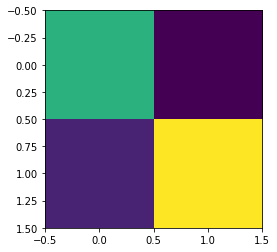

In [11]:
def evaluate(X):
  img_rates = np.zeros((len(X), len(exc_layer)))
  T_show = 150*b2.ms
  rate_mon = b2.SpikeMonitor(exc_layer)
  prev_count = np.zeros((len(exc_layer),))
  for i_img, img in enumerate(X):
    input_layer.rates = img.ravel()*max_rate
    b2.run(T_show, report=None)
    img_rates[i_img,:] = np.array(rate_mon.count-prev_count)
    prev_count += img_rates[i_img,:]
    input_layer.rates = img.ravel()*0*b2.Hz
    b2.run(T_rest, report=None)
    #del rate_mon
  return img_rates
  
stdp_synapses.stdp_rate = 0
train_rates = evaluate(X_train)
nrn_class_count = np.zeros((len(patterns),len(exc_layer)))
for i_class in range(len(patterns)):
  nrn_class_count[i_class,:] = np.sum(train_rates[np.equal(y_train,i_class),:], axis=0)
plt.imshow(nrn_class_count)  
neuron_class = np.argmax(nrn_class_count, axis=0)
print(neuron_class)
print(train_rates)

## Оценка точности классификации на тестовой выборке

In [12]:
test_rates = evaluate(X_test)
print(test_rates)

[[ 2. 20.]
 [20.  5.]
 [ 6.  4.]
 [23.  1.]
 [ 6. 17.]
 [ 6.  1.]
 [20.  3.]
 [17.  0.]
 [17.  3.]
 [ 2. 19.]
 [27.  5.]
 [ 3. 26.]]


[1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.]
[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1]
Accuracy: 1.0


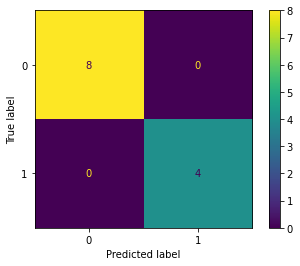

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix

def predict(rates, neuron_class):
  y = np.ones(rates.shape[0])*np.nan
  for i,x in enumerate(rates):
    y[i] = neuron_class[np.argmax(x)]
  return y

test_prediction = predict(test_rates, neuron_class)

print(test_prediction)
print(y_test)
acc = accuracy_score(y_test, test_prediction)
cm = confusion_matrix(y_test, test_prediction)
print(f"Accuracy: {acc}")
cm_display = ConfusionMatrixDisplay(cm).plot()


In [14]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/4SCrZ6bEqAc?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')


WARNING    /usr/local/lib/python3.7/dist-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
 [py.warnings]
  warnings.warn("Consider using IPython.display.IFrame instead")

